# Modellvergleich:
Dieses Notebook:
1. Erstellt Datenlader für MedMNIST (`pathmnist` oder `tissuemnist`)  
2. Trainiert Modelle mit der entsprechenden geladenen Konfiguration
3. Evaluiert die Modelle mit möglichen Metriken
4. Skizziert das Radardiagramm und die Confusion-Matrizen

### Imports, Config, Functions

In [ ]:
import os, json, time, random
import numpy as np
import torch
import tqdm as notebook_tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Subset
import seaborn as sns
from torchmetrics.classification import ConfusionMatrix
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    
)
from sklearn.model_selection import KFold
from medmnist import INFO, TissueMNIST, PathMNIST
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler 
from src.static_model import StaticCNN 
from src.dynamic_model import DynamicCNN
import matplotlib.pyplot as plt

def set_seeds(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise RuntimeError("no cuda gpu found")
print("Device:", device)

Device: cuda


c:\Users\nikzh\Documents\BA\nas-medimg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIG
CFG = {
    "dataset": "pathmnist",
    "img_size": 64,
    "batch": 64,
    "seed": 42,
    "device": device,
    "retrain_epochs": 20,
    "version": 2
}

os.makedirs("outputs", exist_ok=True)
set_seeds(CFG["seed"])

In [3]:
def build_loaders(dataset_name: str, img_size: int, batch: int, seed: int):
    info = INFO[dataset_name]
    n_classes = len(info["label"])
    class_names = [str(k) for k in range(n_classes)] 
    n_channels = info["n_channels"]
    as_rgb = (n_channels == 3)

    mean = [0.5] * n_channels
    std  = [0.5] * n_channels

    train_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    DataSet = PathMNIST if dataset_name == "pathmnist" else TissueMNIST
    train_set = DataSet(split="train", download=True, transform=train_tf, as_rgb=as_rgb)
    test_set  = DataSet(split="test",  download=True, transform=test_tf, as_rgb=as_rgb)

    g = torch.Generator().manual_seed(seed)
    val_size = int(0.1 * len(train_set))
    train_set, val_set = random_split(train_set, [len(train_set)-val_size, val_size], generator=g)

    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, val_loader, test_loader, n_channels, n_classes, class_names

In [4]:
train_loader, val_loader, test_loader, IN_CH, N_CLASSES, CLASS_NAMES = build_loaders(
    CFG["dataset"], CFG["img_size"], CFG["batch"], CFG["seed"]
)

print("IN_CH:", IN_CH)
print("N_CLASSES:", N_CLASSES)
print("CLASS_NAMES:", CLASS_NAMES)

IN_CH: 3
N_CLASSES: 9
CLASS_NAMES: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [5]:
# train/eval
def train_epoch(model, loader, loss_fn, opt, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for X, y in loader:
        y = y.squeeze().long()
        X, y = X.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        total += bs
    return total_loss / total, 100.0 * total_correct / total

@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for X, y in loader:
        y = y.squeeze().long()
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        total += bs
    return total_loss / total, 100.0 * total_correct / total

In [17]:
def evaluate_model(model, data_loader, device, n_classes):
   
    model.eval()
    model.to(device)

    all_logits = []
    all_targets = []

    total_time = 0.0
    total_samples = 0

    with torch.inference_mode():
        for X, y in data_loader:
            y = y.squeeze().long()

            X = X.to(device)
            y = y.to(device)

            bs = X.size(0)
            total_samples += bs

            # --- Inferenzzeit messen ---
            if device.type == "cuda":
                torch.cuda.synchronize()
            start = time.perf_counter()

            logits = model(X)

            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()

            total_time += (end - start)

            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())

    all_logits = torch.cat(all_logits)          
    all_targets = torch.cat(all_targets)
    probs = torch.softmax(all_logits, dim=1).numpy()
    preds = probs.argmax(axis=1)
    targets = all_targets.numpy()

    # Accuracy, Precision, Recall, F1-Score
    acc = accuracy_score(targets, preds)

    prec, rec, f1, _ = precision_recall_fscore_support(
        targets, preds, average="macro", zero_division=0
    )

    # AUC, AP
    y_true_1hot = np.eye(n_classes)[targets]

    try:
        auc = roc_auc_score(y_true_1hot, probs, multi_class="ovr", average="macro")
    except ValueError:
        auc = float("nan")

    try:
        ap = average_precision_score(y_true_1hot, probs, average="macro")
    except ValueError:
        ap = float("nan")

    # Confusion Matrix
    cm = confusion_matrix(targets, preds, labels=np.arange(n_classes))

    # G-Mean
    # per-class Recall:
    _, recalls_per_class, _, _ = precision_recall_fscore_support(
        targets, preds, average=None, zero_division=0
    )
    # geometrisches Mittel
    eps = 1e-8
    gmean = np.prod(recalls_per_class + eps) ** (1.0 / len(recalls_per_class))

    # Inferenzeit
    avg_inf_time = total_time / max(1, total_samples)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "ap": ap,
        "confusion_matrix": cm,
        "gmean": gmean,
        "avg_inf_time_sec_per_image": avg_inf_time,
    }
    return metrics

In [ ]:
def plot_confmat(confmat, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_tensor,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


### Manuelles-CNN 

In [18]:
# Manuelles CNN evaluieren

model = StaticCNN(input_shape=IN_CH, hidden_units=16, output_shape=N_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss()

model.load_state_dict(torch.load("best_pathmnist_cnn.pt", map_location=device))
ts_loss, ts_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"TEST loss {ts_loss:.4f} | acc {ts_acc:.2f}%")

metrics_static_cnn = evaluate_model(model, test_loader, CFG["device"], N_CLASSES)
metrics_static_cnn

TEST loss 0.7119 | acc 81.38%


{'accuracy': 0.8137883008356546,
 'precision': 0.7868650849380591,
 'recall': 0.7855777723747931,
 'f1': 0.768720719834811,
 'auc': 0.9715702811878936,
 'ap': 0.8541119077400092,
 'confusion_matrix': array([[1040,    0,    0,    0,    0,  296,    0,    0,    2],
        [   0,  847,    0,    0,    0,    0,    0,    0,    0],
        [   9,    0,  300,    0,    0,    7,    0,   23,    0],
        [   1,    0,   93,  535,    0,    0,    0,    0,    5],
        [  59,   28,    0,    0,  839,    0,   91,    0,   18],
        [  62,    0,  113,    0,   11,  359,    0,   47,    0],
        [   3,    0,   29,    6,   15,    0,  661,    9,   18],
        [   6,    0,  168,    0,    5,   57,    5,  148,   32],
        [   1,    0,   54,   10,   14,    3,   36,    1, 1114]]),
 'gmean': np.float64(0.7561830991867916),
 'avg_inf_time_sec_per_image': 0.00010542669916404852}

### Random-Search optimiertes CNN

In [8]:
# Modell mit Random-Search-NAS-Parametern trainieren

with open(f"outputs/nas_pathmnist_v{CFG["version"]}/Random/best_params.json", "r") as f:  
    best = json.load(f)
print("Loaded params:", best)

conv_channels = [best[f"conv_ch_{i}"] for i in range(best["n_conv_layers"])]
linear_units = [best[f"linear_units_{i}"] for i in range(best["n_linear_layers"])]

model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=best["kernel_size"],
            pool_type=best["pool_type"],
            pool_every=best["pool_every"],
            dropout=best["dropout"],
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)

opt = optim.SGD(model.parameters(), lr=best["lr"], momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

epoch_train_loss, epoch_train_acc = [], []
epoch_val_loss,   epoch_val_acc   = [], []
best_val = float("inf")
best_path = os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/Random", f"best_{CFG['dataset']}_random_nas.pt")

for ep in range(1, CFG["retrain_epochs"] + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, opt, device)
    vl_loss, vl_acc = eval_epoch(model, val_loader, loss_fn, device)
    epoch_train_loss.append(tr_loss); epoch_train_acc.append(tr_acc)
    epoch_val_loss.append(vl_loss);   epoch_val_acc.append(vl_acc)
    print(f"[retrain {ep:02d}] tr {tr_loss:.4f}/{tr_acc:.2f}% | val {vl_loss:.4f}/{vl_acc:.2f}%")
    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), best_path)
        print(f"  ↳ saved {best_path}")

model.load_state_dict(torch.load(best_path, map_location=device))
ts_loss, ts_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"TEST loss {ts_loss:.4f} | acc {ts_acc:.2f}%")

np.savez(
    os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/Random", f"logs_{CFG['dataset']}_epoch_random_nas.npz"),
    epoch_train_loss=np.array(epoch_train_loss, dtype=np.float32),
    epoch_val_loss=np.array(epoch_val_loss, dtype=np.float32),
    epoch_train_acc=np.array(epoch_train_acc, dtype=np.float32),
    epoch_val_acc=np.array(epoch_val_acc, dtype=np.float32),
    test_loss=np.array([ts_loss], dtype=np.float32),
    test_acc=np.array([ts_acc], dtype=np.float32)
)
print("Saved logs ->", os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/Random", f"logs_{CFG['dataset']}_epoch_random_nas.npz"))


Loaded params: {'n_conv_layers': 11, 'n_linear_layers': 1, 'conv_ch_0': 256, 'conv_ch_1': 32, 'conv_ch_2': 32, 'conv_ch_3': 64, 'conv_ch_4': 256, 'conv_ch_5': 128, 'conv_ch_6': 32, 'conv_ch_7': 64, 'conv_ch_8': 64, 'conv_ch_9': 32, 'conv_ch_10': 256, 'linear_units_0': 256, 'kernel_size': 3, 'pool_every': 4, 'pool_type': 'max', 'dropout': 0.3130409182520984, 'lr': 0.0008469597143996557}
[retrain 01] tr 0.8347/71.51% | val 0.4428/84.24%
  ↳ saved outputs/nas_pathmnist_v2/Random\best_pathmnist_random_nas.pt
[retrain 02] tr 0.3179/89.41% | val 0.2463/91.44%
  ↳ saved outputs/nas_pathmnist_v2/Random\best_pathmnist_random_nas.pt
[retrain 03] tr 0.2228/92.54% | val 0.3041/89.38%
[retrain 04] tr 0.1815/94.01% | val 0.1502/94.89%
  ↳ saved outputs/nas_pathmnist_v2/Random\best_pathmnist_random_nas.pt
[retrain 05] tr 0.1514/94.96% | val 0.1794/93.91%
[retrain 06] tr 0.1359/95.56% | val 0.1236/95.93%
  ↳ saved outputs/nas_pathmnist_v2/Random\best_pathmnist_random_nas.pt
[retrain 07] tr 0.1205/96.0

In [19]:
with open(f"outputs/nas_pathmnist_v{CFG["version"]}/Random/best_params.json", "r") as f:  
    best = json.load(f)
print("Loaded params:", best)

conv_channels = [best[f"conv_ch_{i}"] for i in range(best["n_conv_layers"])]
linear_units = [best[f"linear_units_{i}"] for i in range(best["n_linear_layers"])]

model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=best["kernel_size"],
            pool_type=best["pool_type"],
            pool_every=best["pool_every"],
            dropout=best["dropout"],
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)
model.load_state_dict(torch.load(f"outputs/nas_pathmnist_v{CFG["version"]}/Random/best_{CFG['dataset']}_random_nas.pt", map_location=device))
metrics_random_nas_cnn = evaluate_model(model, test_loader, CFG["device"], N_CLASSES)
metrics_random_nas_cnn

Loaded params: {'n_conv_layers': 11, 'n_linear_layers': 1, 'conv_ch_0': 256, 'conv_ch_1': 32, 'conv_ch_2': 32, 'conv_ch_3': 64, 'conv_ch_4': 256, 'conv_ch_5': 128, 'conv_ch_6': 32, 'conv_ch_7': 64, 'conv_ch_8': 64, 'conv_ch_9': 32, 'conv_ch_10': 256, 'linear_units_0': 256, 'kernel_size': 3, 'pool_every': 4, 'pool_type': 'max', 'dropout': 0.3130409182520984, 'lr': 0.0008469597143996557}


{'accuracy': 0.8593314763231198,
 'precision': 0.8635019691417524,
 'recall': 0.8531833809534307,
 'f1': 0.8379353759131651,
 'auc': 0.986637536423509,
 'ap': 0.9263266449050166,
 'confusion_matrix': array([[ 875,    0,    2,    0,    1,  439,   12,    0,    9],
        [   0,  847,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  302,    0,    0,   34,    0,    3,    0],
        [   0,    0,    5,  628,    0,    0,    0,    0,    1],
        [  25,   52,    0,    0,  933,    0,    5,    0,   20],
        [   0,    0,    3,    0,    0,  572,    0,   16,    1],
        [   3,    0,    5,   31,    2,    0,  648,    9,   43],
        [   0,    0,   85,    2,    4,   96,    3,  188,   43],
        [   2,    0,    7,   26,    0,    1,   18,    2, 1177]]),
 'gmean': np.float64(0.8302099003108677),
 'avg_inf_time_sec_per_image': 0.00017803976322048535}

### Bayesianisch optimiertes CNN

In [10]:
# Modell mit Bayesian-Optimierungsverfahren-NAS-Parameter trainieren

with open(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE/best_params.json", "r") as f: 
    best = json.load(f)
print("Loaded params:", best)

conv_channels = [best[f"conv_ch_{i}"] for i in range(best["n_conv_layers"])]
linear_units = [best[f"linear_units_{i}"] for i in range(best["n_linear_layers"])]

model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=best["kernel_size"],
            pool_type=best["pool_type"],
            pool_every=best["pool_every"],
            dropout=best["dropout"],
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)

opt = optim.SGD(model.parameters(), lr=best["lr"], momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

epoch_train_loss, epoch_train_acc = [], []
epoch_val_loss,   epoch_val_acc   = [], []
best_val = float("inf")
best_path = os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE", f"best_{CFG['dataset']}_tpe_nas.pt")

for ep in range(1, CFG["retrain_epochs"] + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, opt, device)
    vl_loss, vl_acc = eval_epoch(model, val_loader, loss_fn, device)
    epoch_train_loss.append(tr_loss); epoch_train_acc.append(tr_acc)
    epoch_val_loss.append(vl_loss);   epoch_val_acc.append(vl_acc)
    print(f"[retrain {ep:02d}] tr {tr_loss:.4f}/{tr_acc:.2f}% | val {vl_loss:.4f}/{vl_acc:.2f}%")
    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), best_path)
        print(f"  ↳ saved {best_path}")

model.load_state_dict(torch.load(best_path, map_location=device))
ts_loss, ts_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"TEST loss {ts_loss:.4f} | acc {ts_acc:.2f}%")

np.savez(
    os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE", f"logs_{CFG['dataset']}_epoch_tpe_nas.npz"),
    epoch_train_loss=np.array(epoch_train_loss, dtype=np.float32),
    epoch_val_loss=np.array(epoch_val_loss, dtype=np.float32),
    epoch_train_acc=np.array(epoch_train_acc, dtype=np.float32),
    epoch_val_acc=np.array(epoch_val_acc, dtype=np.float32),
    test_loss=np.array([ts_loss], dtype=np.float32),
    test_acc=np.array([ts_acc], dtype=np.float32)
)
print("Saved logs ->", os.path.join(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE", f"logs_{CFG['dataset']}_epoch_tpe_nas.npz"))


Loaded params: {'n_conv_layers': 8, 'n_linear_layers': 1, 'conv_ch_0': 256, 'conv_ch_1': 16, 'conv_ch_2': 256, 'conv_ch_3': 128, 'conv_ch_4': 32, 'conv_ch_5': 128, 'conv_ch_6': 64, 'conv_ch_7': 64, 'linear_units_0': 128, 'kernel_size': 3, 'pool_every': 2, 'pool_type': 'max', 'dropout': 0.3986671360118502, 'lr': 0.0037019571035174586}
[retrain 01] tr 0.6125/78.76% | val 0.5068/81.79%
  ↳ saved outputs/nas_pathmnist_v2/TPE\best_pathmnist_tpe_nas.pt
[retrain 02] tr 0.2830/90.50% | val 0.2314/92.04%
  ↳ saved outputs/nas_pathmnist_v2/TPE\best_pathmnist_tpe_nas.pt
[retrain 03] tr 0.2022/93.35% | val 0.2074/92.79%
  ↳ saved outputs/nas_pathmnist_v2/TPE\best_pathmnist_tpe_nas.pt
[retrain 04] tr 0.1700/94.38% | val 0.1613/94.33%
  ↳ saved outputs/nas_pathmnist_v2/TPE\best_pathmnist_tpe_nas.pt
[retrain 05] tr 0.1432/95.31% | val 0.1413/95.50%
  ↳ saved outputs/nas_pathmnist_v2/TPE\best_pathmnist_tpe_nas.pt
[retrain 06] tr 0.1246/95.90% | val 0.1345/95.31%
  ↳ saved outputs/nas_pathmnist_v2/TPE\

In [20]:
with open(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE/best_params.json", "r") as f:  
    best = json.load(f)
print("Loaded params:", best)

conv_channels = [best[f"conv_ch_{i}"] for i in range(best["n_conv_layers"])]
linear_units = [best[f"linear_units_{i}"] for i in range(best["n_linear_layers"])]

model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=best["kernel_size"],
            pool_type=best["pool_type"],
            pool_every=best["pool_every"],
            dropout=best["dropout"],
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)
model.load_state_dict(torch.load(f"outputs/nas_pathmnist_v{CFG["version"]}/TPE/best_{CFG['dataset']}_tpe_nas.pt", map_location=device))
metrics_tpe_nas_cnn = evaluate_model(model, test_loader, CFG["device"], N_CLASSES)
metrics_tpe_nas_cnn

Loaded params: {'n_conv_layers': 8, 'n_linear_layers': 1, 'conv_ch_0': 256, 'conv_ch_1': 16, 'conv_ch_2': 256, 'conv_ch_3': 128, 'conv_ch_4': 32, 'conv_ch_5': 128, 'conv_ch_6': 64, 'conv_ch_7': 64, 'linear_units_0': 128, 'kernel_size': 3, 'pool_every': 2, 'pool_type': 'max', 'dropout': 0.3986671360118502, 'lr': 0.0037019571035174586}


{'accuracy': 0.9069637883008357,
 'precision': 0.891514529535448,
 'recall': 0.8676297753475514,
 'f1': 0.8668002640795831,
 'auc': 0.9909413812143328,
 'ap': 0.9367100605473256,
 'confusion_matrix': array([[1306,    0,    1,    0,    0,   31,    0,    0,    0],
        [   0,  847,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  251,    0,    0,   74,    0,    2,   12],
        [   0,    0,   12,  618,    0,    0,    1,    0,    3],
        [  38,   78,    0,    0,  858,    0,   32,    0,   29],
        [   0,    0,   21,    0,    0,  567,    0,    4,    0],
        [   0,    0,    6,    1,    0,    0,  698,    9,   27],
        [   0,    0,   57,    0,    2,  111,    2,  179,   70],
        [   0,    0,    4,   13,    2,    0,   23,    3, 1188]]),
 'gmean': np.float64(0.843362840894847),
 'avg_inf_time_sec_per_image': 0.0001445084818809755}

### Radardiagramm + Confusion Matrizen

In [37]:
def plot_radar(models_metrics, title="Model Comparison (Radar)"):

    metric_keys = ["accuracy", "precision", "recall", "f1", "ap", "auc", "gmean"] 
    metric_labels = ["Accuracy", "Precision", "Recall", "F1-Score", "AP", "AUC", "G-Mean"]

    # Anzahl Achsen
    N = len(metric_keys)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for model_name, m in models_metrics.items():
        values = [m[k] for k in metric_keys]
        values = np.array(values, dtype=float)

        values = np.concatenate((values, [values[0]]))

        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)

    #ax.set_ylim(0.0, 1.0)
    #ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    #ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"])

    ax.set_title(title, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))

    plt.tight_layout()
    plt.show()
    # plt.savefig("cnn_nas_radar.pdf")  


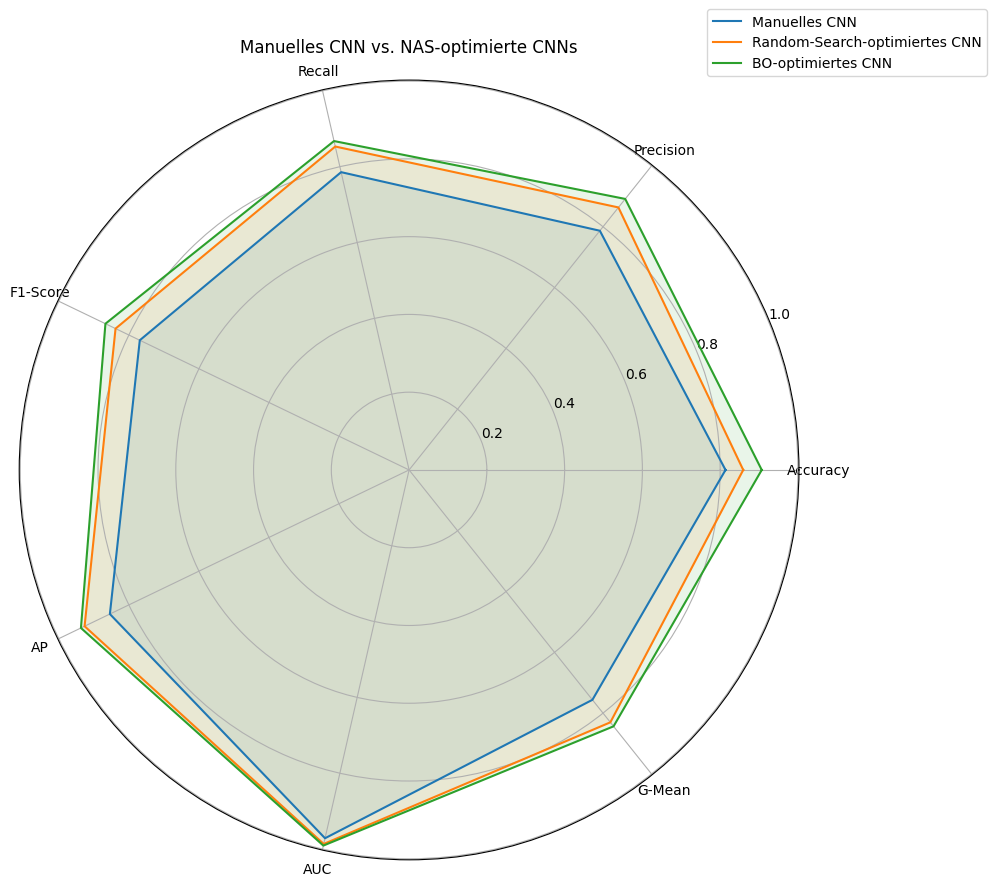

In [42]:
models_metrics = {
    "Manuelles CNN": metrics_static_cnn,
    "Random-Search-optimiertes CNN": metrics_random_nas_cnn,
    "BO-optimiertes CNN": metrics_tpe_nas_cnn,
}

plot_radar(models_metrics, title="Manuelles CNN vs. NAS-optimierte CNNs")


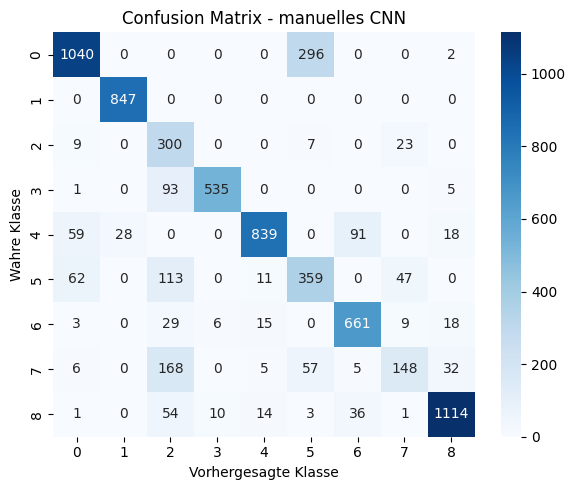

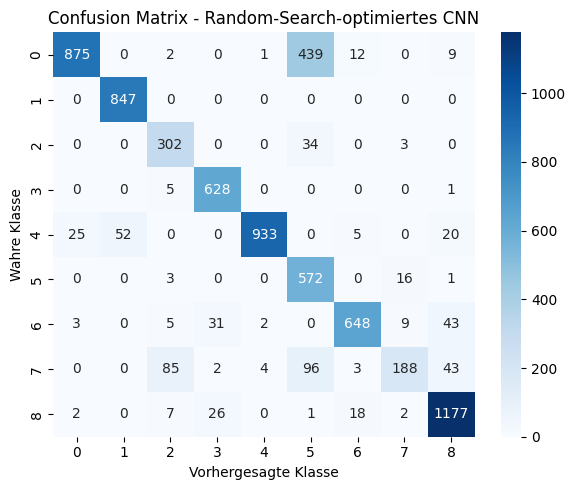

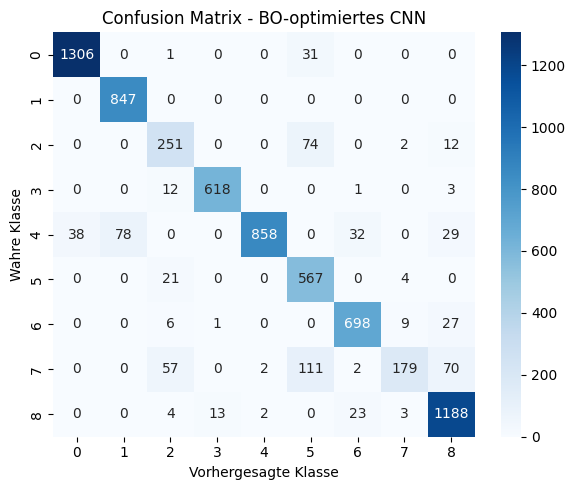

In [40]:
def plot_confmat(confmat, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confmat,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Vorhergesagte Klasse")
    plt.ylabel("Wahre Klasse")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confmat(metrics_static_cnn["confusion_matrix"], CLASS_NAMES,
             title="Confusion Matrix - manuelles CNN")

plot_confmat(metrics_random_nas_cnn["confusion_matrix"], CLASS_NAMES,
             title="Confusion Matrix - Random-Search-optimiertes CNN")
plot_confmat(metrics_tpe_nas_cnn["confusion_matrix"], CLASS_NAMES,
             title="Confusion Matrix - BO-optimiertes CNN")
